<a href="https://colab.research.google.com/github/Zesmat/Mentorness/blob/main/Market_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Data Preprocessing**

## **Load Data**

In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import LSTM, Dense,Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score



data=pd.read_csv(r'/content/drive/MyDrive/Market Price Prediction/MarketPricePrediction.csv')
# Convert date column to datetime
data['date'] = pd.to_datetime(data['date'], format='%B-%Y')
# Set the date as the index
print(data.shape)
data.head()

(10227, 10)


,market,month,year,quantity,priceMin,priceMax,priceMod,state,city,date
0,ABOHAR(PB),January,2005,2350,404,493,446,PB,ABOHAR,2005-01-01
1,ABOHAR(PB),January,2006,900,487,638,563,PB,ABOHAR,2006-01-01
2,ABOHAR(PB),January,2010,790,1283,1592,1460,PB,ABOHAR,2010-01-01
3,ABOHAR(PB),January,2011,245,3067,3750,3433,PB,ABOHAR,2011-01-01
4,ABOHAR(PB),January,2012,1035,523,686,605,PB,ABOHAR,2012-01-01


## **Encoding Values**

In [ ]:
label_encoder_city = LabelEncoder()
data['city'] = label_encoder_city.fit_transform(data['city'])

label_encoder_state = LabelEncoder()
data['state'] = label_encoder_state.fit_transform(data['state'])

label_encoder_market = LabelEncoder()
data['market'] = label_encoder_state.fit_transform(data['market'])


In [ ]:
#data = pd.get_dummies(data, columns=['market', 'state', 'city', 'month'])


Cheki

In [ ]:
data.fillna(method='ffill', inplace=True)
data = data.sort_values(by='date')

# Check for missing values
print(data.isnull().sum())



year               0
quantity           0
priceMin           0
priceMax           0
priceMod           0
                  ..
month_March        0
month_May          0
month_November     0
month_October      0
month_September    0
Length: 276, dtype: int64


In [ ]:
# Create lagged features
for lag in range(1, 13):
    data[f'quantity_lag_{lag}'] = data['quantity'].shift(lag)


# Create rolling statistics
data['rolling_mean_3'] = data['quantity'].rolling(window=3).mean()
data['rolling_std_3'] = data['quantity'].rolling(window=3).std()

# Check if the data DataFrame is empty

if data.empty:
    raise ValueError("Dataframe is empty. Cannot proceed.")

# Drop NA values created by lagging and rolling
data.dropna(inplace=True)

# Select features and target
features = ['priceMax', 'priceMin', 'priceMod'] + [col for col in data.columns if col.startswith(('month_', 'city_', 'state_', 'market_', 'quantity_lag_'))]
target = data['quantity']

# **Exploratory Data Analysis**

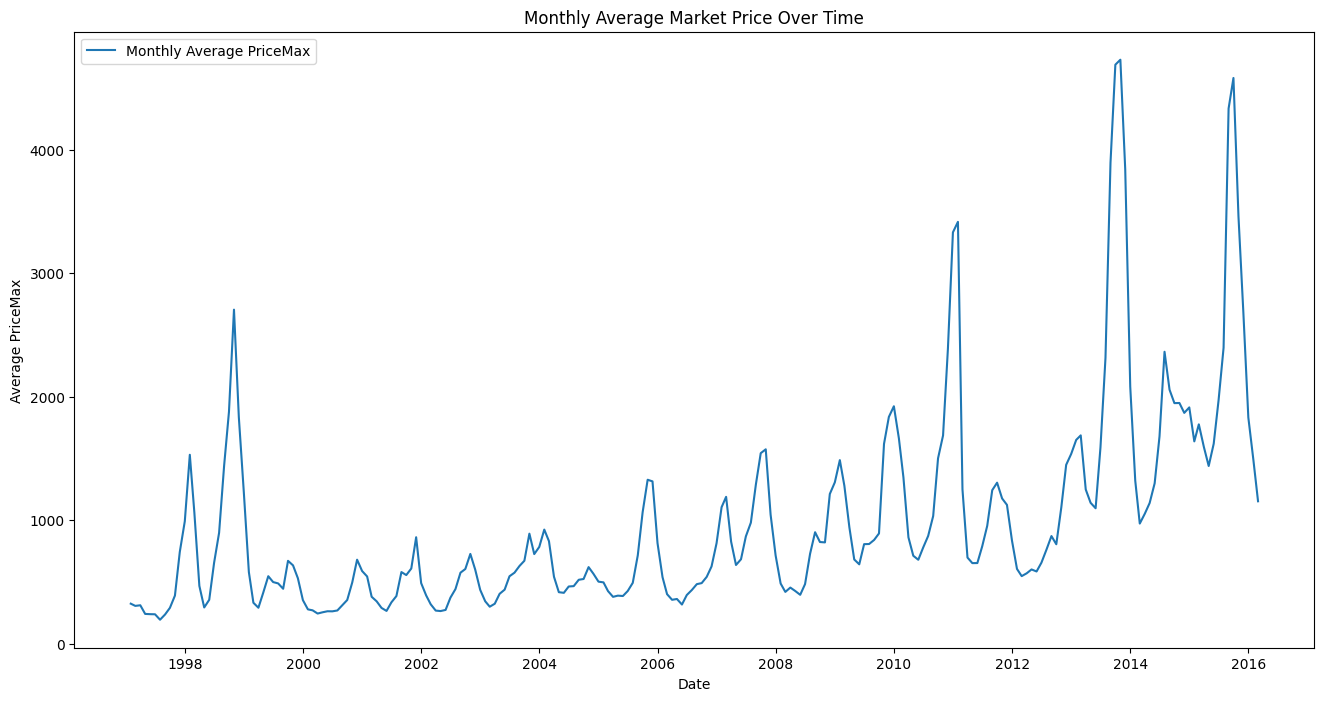

               year      quantity      priceMin      priceMax      priceMod  \
count  10215.000000  1.021500e+04  10215.000000  10215.000000  10215.000000   
mean    2009.037592  7.648336e+04    647.514342   1213.751738    985.066373   
min     1997.000000  2.000000e+01     16.000000    145.000000     80.000000   
25%     2006.000000  8.875000e+03    210.000000    558.000000    449.000000   
50%     2009.000000  2.740000e+04    441.000000    924.000000    747.000000   
75%     2013.000000  8.788350e+04    829.000000   1528.000000   1250.000000   
max     2016.000000  1.639032e+06   6000.000000   8192.000000   6400.000000   
std        4.352555  1.244234e+05    673.310673    979.801319    818.628967   

                                date  quantity_lag_1  quantity_lag_2  \
count                          10215    1.021500e+04    1.021500e+04   
mean   2009-06-28 09:00:45.462554880    7.649047e+04    7.649972e+04   
min              1997-01-01 00:00:00    2.000000e+01    2.000000e+01   


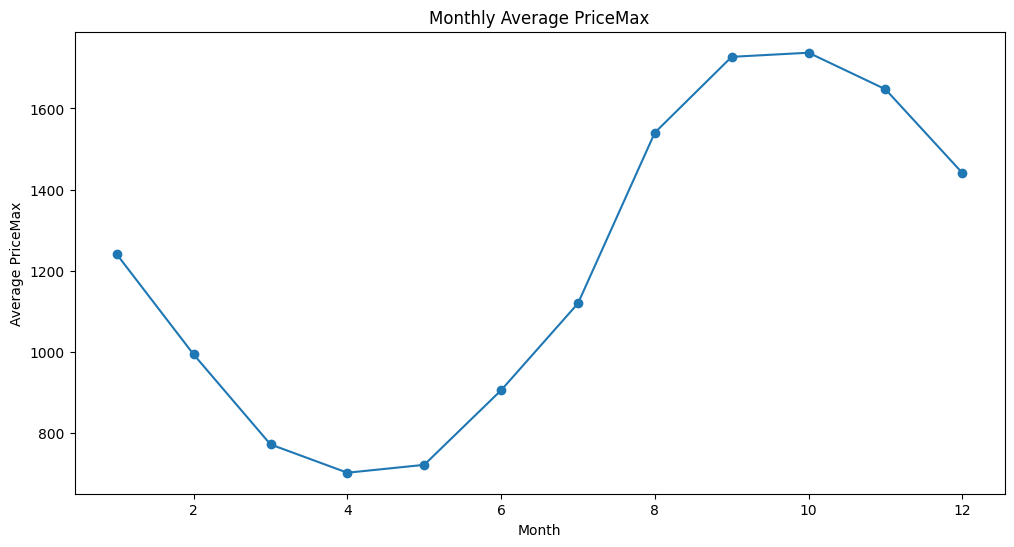

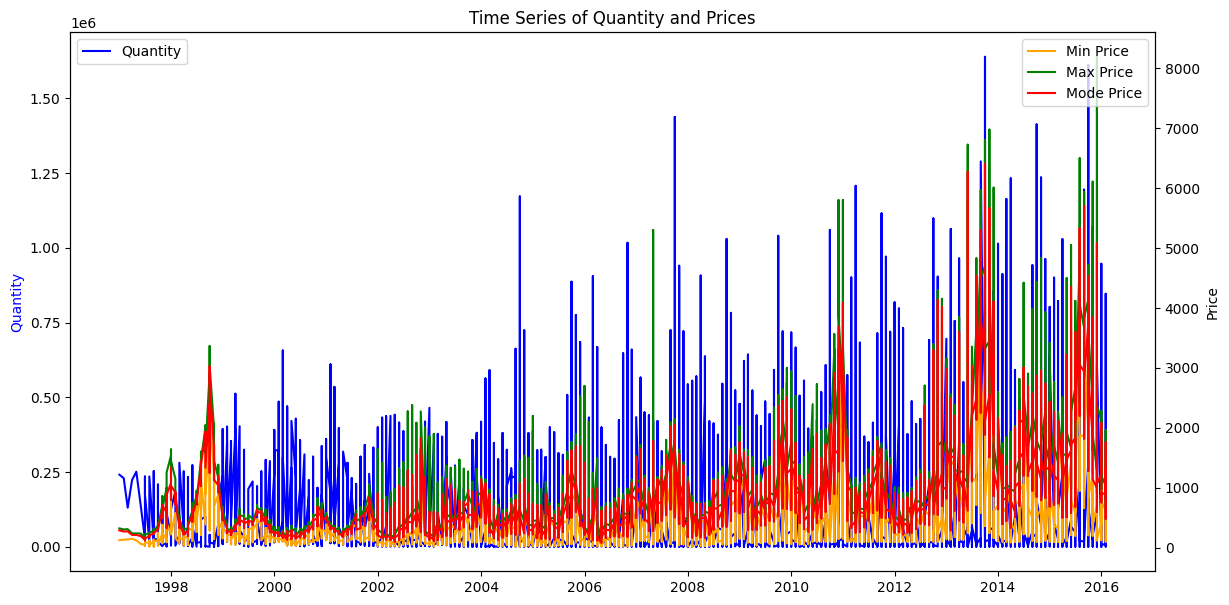

In [ ]:
import pandas as pd

import matplotlib.pyplot as plt

data.index = pd.to_datetime(data['date'])
# Aggregate the data by month and calculate the mean priceMax for each month
monthly_avg = data['priceMax'].resample('M').mean()

# Plot the monthly average priceMax
plt.figure(figsize=(16, 8))
plt.plot(monthly_avg, label='Monthly Average PriceMax')
plt.xlabel('Date')
plt.ylabel('Average PriceMax')
plt.title('Monthly Average Market Price Over Time')
plt.legend()
plt.show()


# Display summary statistics
print(data.describe())

# Check for seasonality and trends
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month

monthly_avg = data.groupby('month')['priceMax'].mean()
plt.figure(figsize=(12, 6))
plt.plot(monthly_avg.index, monthly_avg, marker='o')
plt.title('Monthly Average PriceMax')
plt.xlabel('Month')
plt.ylabel('Average PriceMax')
plt.show()

# Plot the time series for quantity and prices
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot quantity on primary y-axis
ax1.plot(data.index, data['quantity'], color='blue', label='Quantity')
ax1.set_ylabel('Quantity', color='blue')

# Create a secondary y-axis for prices
ax2 = ax1.twinx()
ax2.plot(data.index, data['priceMin'], color='orange', label='Min Price')
ax2.plot(data.index, data['priceMax'], color='green', label='Max Price')
ax2.plot(data.index, data['priceMod'], color='red', label='Mode Price')
ax2.set_ylabel('Price', color='black')

# Show legends for both y-axes
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.title('Time Series of Quantity and Prices')
plt.show()


## **Seasonal Decomposition**

<Figure size 1500x700 with 0 Axes>

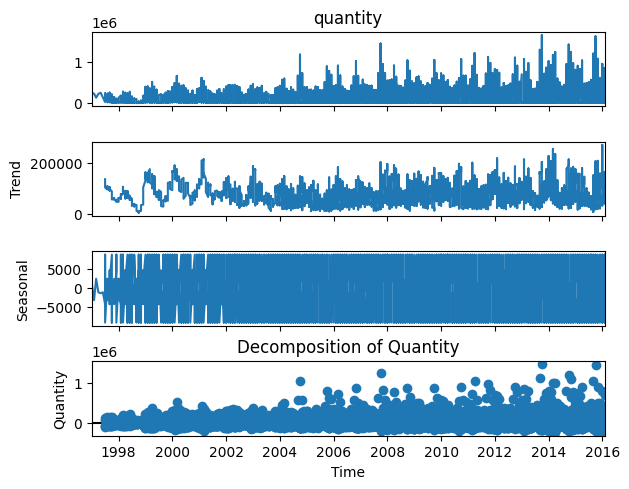

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
# Decompose the time series (for example on quantity)
decomposition = seasonal_decompose(data['quantity'], model='additive', period=12)
plt.figure(figsize=(15, 7))
decomposition.plot()
plt.xlabel("Time")
plt.ylabel("Quantity")
plt.title("Decomposition of Quantity")
plt.show()

# **Model Building**

## **Data Scaler**

In [ ]:
#Drop rows with NaN values created by shifting
data.dropna(inplace=True)



# Normalize the data
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(data[features])
scaled_data=pd.DataFrame(features_scaled, columns=features)

# Initialize MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Reshape and scale the data in a single step
scaled_data = scaler.fit_transform(np.array(data[features]).reshape(-1, len(features)))

# Verify the shape of the scaled data
print("Shape of scaled data:", scaled_data.shape)

Shape of scaled data: (10215, 285)


## **Splitting Data**

In [ ]:
# Split the data into training and testing sets
# Splitting dataset into training and testing
training_size = int(len(scaled_data) * 0.8)
test_size = len(scaled_data) - training_size

train_data = scaled_data[0:training_size]
test_data = scaled_data[training_size:len(scaled_data)]

train_target = target[0:training_size]
test_target = target[training_size:len(target)]


# Verify the shapes of the resulting splits
print("Train Data Shape:", train_data.shape)
print("Train Target Shape:", train_target.shape)
print("Test Data Shape:", test_data.shape)
print("Test Target Shape:", test_target.shape)

# Print first few rows of train and test data
print("Train Data Sample:")
print(train_data[:5])
print("Train Target Sample:")
print(train_target[:5])
print("Test Data Sample:")
print(test_data[:5])
print("Test Target Sample:")
print(test_target[:5])

Train Data Shape: (8172, 285)
Train Target Shape: (8172,)
Test Data Shape: (2043, 285)
Test Target Shape: (2043,)
Train Data Sample:
[[0.02212004 0.01838235 0.03322785 ... 0.10919505 0.1196721  0.13730406]
 [0.01988319 0.01971925 0.03022152 ... 0.11749273 0.10919505 0.1196721 ]
 [0.02050454 0.0203877  0.03053797 ... 0.14493732 0.11749273 0.10919505]
 [0.01180564 0.02222594 0.02120253 ... 0.10694736 0.14493732 0.11749273]
 [0.0115571  0.01788102 0.0210443  ... 0.09533914 0.10694736 0.14493732]]
Train Target Sample:
5400    241225
5421    229550
5442    130885
5462    223608
5482    251132
Name: quantity, dtype: int64
Test Data Sample:
[[0.19050578 0.03442513 0.14287975 ... 0.03879166 0.03478132 0.03125847]
 [0.20566671 0.19786096 0.22468354 ... 0.00344537 0.03879166 0.03478132]
 [0.2321362  0.30999332 0.29462025 ... 0.13083126 0.00344537 0.03879166]
 [0.20566671 0.1114639  0.18085443 ... 0.01440197 0.13083126 0.00344537]
 [0.27476078 0.2772393  0.29398734 ... 0.00397496 0.01440197 0.130

## **Pre-modeling LSTM**

In [ ]:
# Define the sequence length

# Function to create sequences for LSTM
def create_sequences(data,target,sequence_length=1):
    sequences = []
    targets = []
    for i in range(len(data) - sequence_length-1):
        s=data[i:i + sequence_length, 0]
        sequences.append(s)
        targets.append(data[i + sequence_length, 0])
    return np.array(sequences), np.array(targets)


sequence_length = 100
# Prepare the training and testing data
X_train_seq, y_train_seq = create_sequences(train_data,train_target, sequence_length)
X_test_seq, y_test_seq = create_sequences(test_data,test_target, sequence_length)
# Reshape the input data for LSTM
X_train_seq = X_train_seq.reshape(X_train_seq.shape[0], X_train_seq.shape[1],1)
X_test_seq = X_test_seq.reshape(X_test_seq.shape[0], X_test_seq.shape[1],1)


# Verify the shapes of the sequences
print(f"X_train_seq shape: {X_train_seq.shape}")
print(f"y_train_seq shape: {y_train_seq.shape}")
print(f"X_test_seq shape: {X_test_seq.shape}")
print(f"y_test_seq shape: {y_test_seq.shape}")


X_train_seq shape: (8071, 100, 1)
y_train_seq shape: (8071,)
X_test_seq shape: (1942, 100, 1)
y_test_seq shape: (1942,)


In [ ]:
X_train_seq,train_target

(array([[[0.02212004],
         [0.01988319],
         [0.02050454],
         ...,
         [0.16341494],
         [0.14875109],
         [0.15931403]],
 
        [[0.01988319],
         [0.02050454],
         [0.01180564],
         ...,
         [0.14875109],
         [0.15931403],
         [0.16378775]],
 
        [[0.02050454],
         [0.01180564],
         [0.0115571 ],
         ...,
         [0.15931403],
         [0.16378775],
         [0.18118553]],
 
        ...,
 
        [[0.62582329],
         [0.57760656],
         [0.82701628],
         ...,
         [0.1697527 ],
         [0.28432956],
         [0.41941096]],
 
        [[0.57760656],
         [0.82701628],
         [0.48030322],
         ...,
         [0.28432956],
         [0.41941096],
         [0.21672673]],
 
        [[0.82701628],
         [0.48030322],
         [0.43469616],
         ...,
         [0.41941096],
         [0.21672673],
         [0.24518454]]]),
 5400    241225
 5421    229550
 5442    130885
 5462  

In [ ]:
pip install tensorflow==2.15.0


In [ ]:
pip install tensorflow==2.10.0

## **LSTM**

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras.callbacks import EarlyStopping
from keras.optimizers import Adam

# Define a function to create the model
# Define a function to create the model
# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(sequence_length, X_train_seq.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1))

optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='mean_squared_error')
#prevents overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
# Build the model
model.fit(X_train_seq, y_train_seq,validation_data=(X_test_seq, y_test_seq),epochs=10,batch_size=32,verbose=1,validation_split=0.2,callbacks=[early_stopping])





Epoch 1/10
253/253 [==============================] - 100s 304ms/step - loss: 0.0034 - val_loss: 0.0043
Epoch 2/10
253/253 [==============================] - 63s 248ms/step - loss: 0.0018 - val_loss: 0.0042
Epoch 3/10
253/253 [==============================] - 62s 244ms/step - loss: 0.0017 - val_loss: 0.0044
Epoch 4/10
253/253 [==============================] - 62s 244ms/step - loss: 0.0016 - val_loss: 0.0041
Epoch 5/10
253/253 [==============================] - 62s 247ms/step - loss: 0.0016 - val_loss: 0.0041
Epoch 6/10
253/253 [==============================] - 61s 240ms/step - loss: 0.0017 - val_loss: 0.0042
Epoch 7/10
253/253 [==============================] - 61s 243ms/step - loss: 0.0016 - val_loss: 0.0042
Epoch 8/10
253/253 [==============================] - 61s 241ms/step - loss: 0.0016 - val_loss: 0.0042
Epoch 9/10
253/253 [==============================] - 59s 235ms/step - loss: 0.0015 - val_loss: 0.0041
Epoch 10/10
253/253 [==============================] - 60s 236ms/step - 

## **Prediction**

61/61 [==============================] - 4s 65ms/step
Training Metrics:
MAE: 21.225653933156952
MSE: 1.3831645389746072
RMSE: 1176.080158396785
R^2: 874.3127286861561

Testing Metrics:
MAE: 41.66129521965806
MSE: 4.026546309833702
RMSE: 2006.6256028052924
R^2: 763.4111397364721


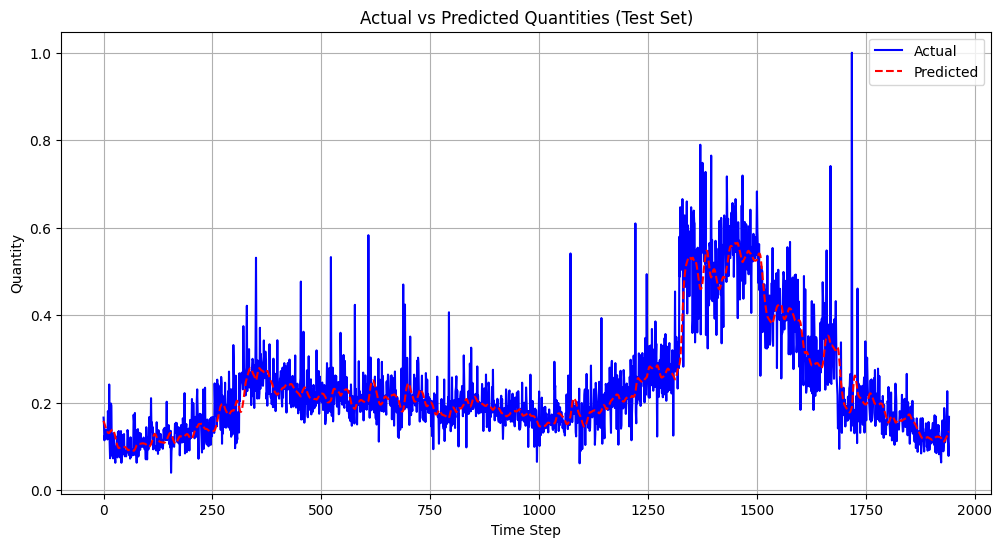

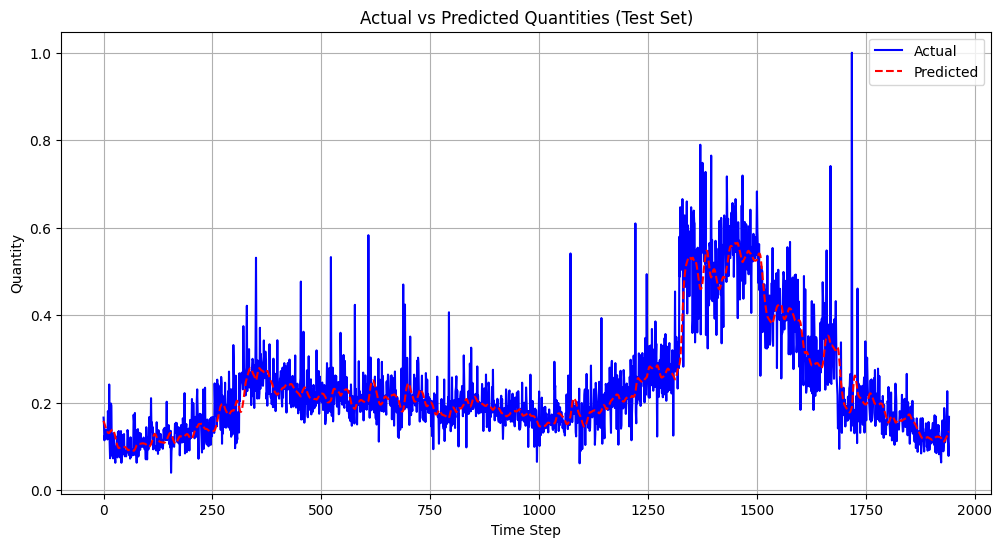

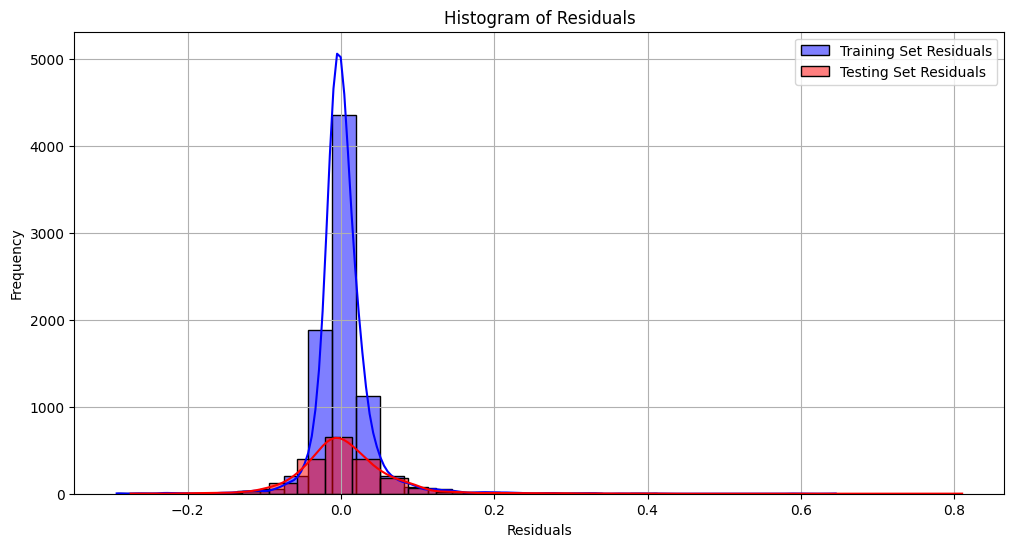

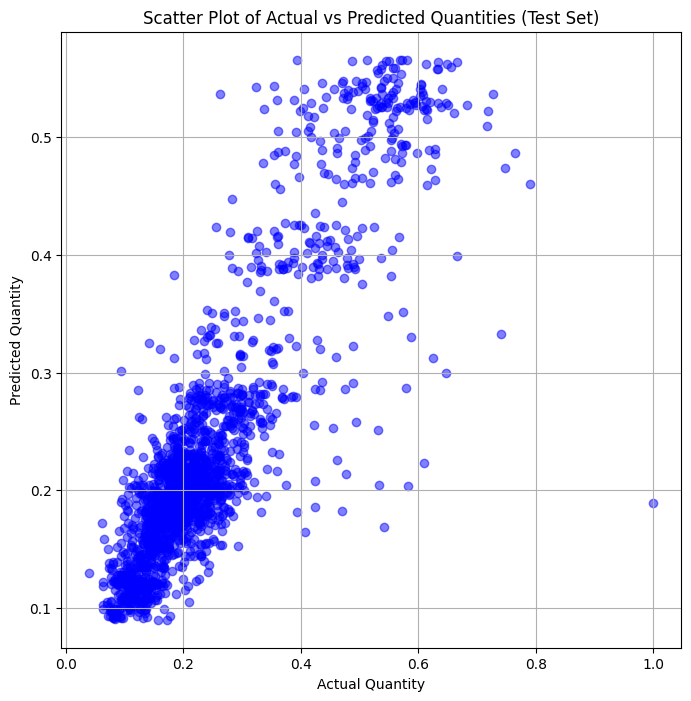

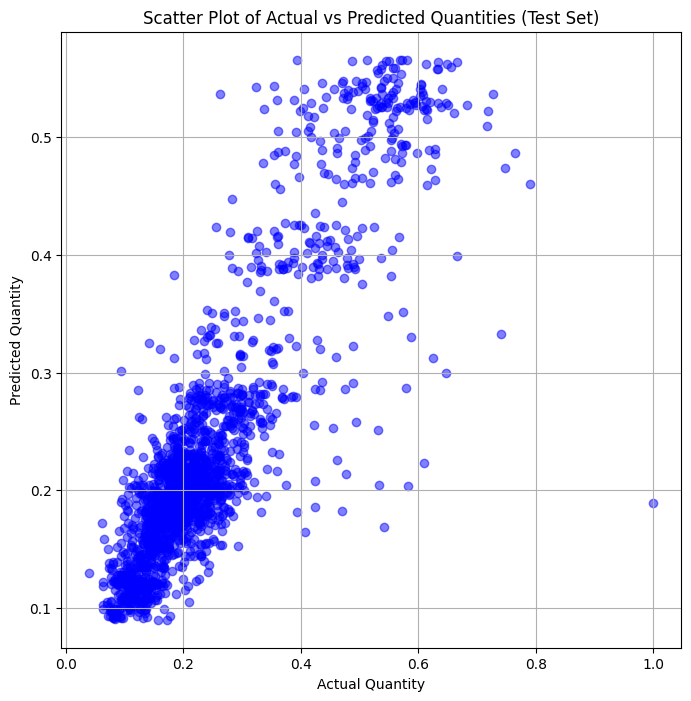

In [ ]:
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
# Define the min and max values of the target variable
min_target = target.min()
max_target = target.max()

 #Initialize MinMaxScaler for target variable
scaler_target = MinMaxScaler(feature_range=(min_target, max_target))

# Fit and transform the target variable for train and test sets
train_target_scaled = scaler_target.fit_transform(train_target.to_numpy().reshape(-1, 1))
test_target_scaled = scaler_target.transform(test_target.to_numpy().reshape(-1, 1))

# Perform predictions using the trained model
train_predict = model.predict(X_train_seq)
test_predict = model.predict(X_test_seq)

# Inverse transform the predictions to original scale
train_predict = scaler_target.inverse_transform(train_predict)
test_predict = scaler_target.inverse_transform(test_predict)

# Evaluate the model
mae_train = mean_absolute_error(y_train_seq, train_predict)*1000
mse_train = mean_squared_error(y_train_seq, train_predict)*1000
rmse_train = np.sqrt(mse_train)*1000
r2_train = r2_score(y_train_seq, train_predict)*1000

mae_test = mean_absolute_error(y_test_seq, test_predict)*1000
mse_test = mean_squared_error(y_test_seq, test_predict)*1000
rmse_test = np.sqrt(mse_test)*1000
r2_test = r2_score(y_test_seq, test_predict)*1000

print('Training Metrics:')
print(f'MAE: {mae_train}')
print(f'MSE: {mse_train}')
print(f'RMSE: {rmse_train}')
print(f'R^2: {r2_train}')
print('\nTesting Metrics:')
print(f'MAE: {mae_test}')
print(f'MSE: {mse_test}')
print(f'RMSE: {rmse_test}')
print(f'R^2: {r2_test}')

import seaborn as sns

# Plot actual vs predicted quantities for test set
plt.figure(figsize=(12, 6))
plt.plot(y_test_seq, label='Actual', color='blue')
plt.plot(test_predict, label='Predicted', color='red', linestyle='--')
plt.title('Actual vs Predicted Quantities (Test Set)')
plt.xlabel('Time Step')
plt.ylabel('Quantity')
plt.legend()
plt.grid(True)
plt.show()

# Calculate residuals
residuals_train = y_train_seq - train_predict.flatten()
residuals_test = y_test_seq - test_predict.flatten()

import seaborn as sns

# Plot actual vs predicted quantities for test set
plt.figure(figsize=(12, 6))
plt.plot(y_test_seq, label='Actual', color='blue')
plt.plot(test_predict, label='Predicted', color='red', linestyle='--')
plt.title('Actual vs Predicted Quantities (Test Set)')
plt.xlabel('Time Step')
plt.ylabel('Quantity')
plt.legend()
plt.grid(True)
plt.show()

# Calculate residuals
residuals_train = y_train_seq - train_predict.flatten()
residuals_test = y_test_seq - test_predict.flatten()

# Plot histograms of residuals
plt.figure(figsize=(12, 6))
sns.histplot(residuals_train, bins=30, kde=True, color='blue', label='Training Set Residuals')
sns.histplot(residuals_test, bins=30, kde=True, color='red', label='Testing Set Residuals')
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

# Scatter plot of actual vs predicted quantities for test set
plt.figure(figsize=(8, 8))
plt.scatter(y_test_seq, test_predict, color='blue', alpha=0.5)
plt.title('Scatter Plot of Actual vs Predicted Quantities (Test Set)')
plt.xlabel('Actual Quantity')
plt.ylabel('Predicted Quantity')
plt.grid(True)
plt.show()


# Scatter plot of actual vs predicted quantities for test set
plt.figure(figsize=(8, 8))
plt.scatter(y_test_seq, test_predict, color='blue', alpha=0.5)
plt.title('Scatter Plot of Actual vs Predicted Quantities (Test Set)')
plt.xlabel('Actual Quantity')
plt.ylabel('Predicted Quantity')
plt.grid(True)
plt.show()


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 dropout (Dropout)           (None, 100, 50)           0         
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-traina